# XGBoost ML Betting Strategy - Training Workflow

This notebook demonstrates the complete workflow for building an ML-based betting strategy using XGBoost.

## Overview

We'll build a binary classifier that predicts win probability for NBA games using:
- Historical odds data from multiple bookmakers
- Line movement patterns
- Sharp vs retail odds discrepancies
- Market consensus and efficiency metrics

The trained model integrates seamlessly with the backtesting framework via `BetOpportunity.confidence`.

## Prerequisites

Ensure dependencies are installed:
```bash
uv add xgboost scikit-learn numpy
```

In [1]:
# Import required libraries
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier

# Project imports
from analytics.backtesting import (
    BacktestConfig,
    BacktestEngine,
    BetConstraintsConfig,
    BetSizingConfig,
)
from analytics.backtesting.models import BacktestEvent
from analytics.ml_strategy_example import FeatureEngineering, XGBoostStrategy
from core.config import Settings
from core.database import async_session_maker
from core.models import EventStatus
from storage.readers import OddsReader

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load settings
settings = Settings()

print("✓ Imports successful")

✓ Imports successful


## 1. Data Preparation

Load historical events with final scores and their corresponding odds snapshots.

In [ ]:
async def load_training_data(
    start_date: datetime,
    end_date: datetime,
    decision_hours_before: int = 1
) -> tuple[list[BacktestEvent], list[list]]:
    """
    Load historical events and their odds snapshots for training.

    Args:
        start_date: Start of training period
        end_date: End of training period
        decision_hours_before: Hours before game to get odds (default: 1)

    Returns:
        Tuple of (events, odds_snapshots)
    """
    async with async_session_maker() as session:
        reader = OddsReader(session)

        # Get completed events with scores
        events = await reader.get_events_by_date_range(
            start_date=start_date,
            end_date=end_date,
            status=EventStatus.FINAL
        )

        print(f"Found {len(events)} completed events")

        # Convert to BacktestEvent and get odds
        backtest_events = []
        odds_snapshots = []

        for event in events:
            bt_event = BacktestEvent.from_db_event(event)
            if bt_event is None:
                continue

            # Get odds at decision time
            decision_time = event.commence_time - timedelta(hours=decision_hours_before)
            odds = await reader.get_odds_at_time(
                event.id,
                decision_time,
                tolerance_minutes=30
            )

            if odds:
                backtest_events.append(bt_event)
                odds_snapshots.append(odds)

        print(f"Loaded {len(backtest_events)} events with odds data")

        return backtest_events, odds_snapshots

# Load data for training period (adjust dates based on your data)
TRAIN_START = datetime(2025, 10, 23)
TRAIN_END = datetime(2025, 10, 31)

events, odds_snapshots = await load_training_data(TRAIN_START, TRAIN_END)

print(f"\nTraining data: {len(events)} games from {TRAIN_START.date()} to {TRAIN_END.date()}")

Found 42 completed events
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=6509e75f3d3674a5cdd2cf12d4031b7c tolerance_minutes=30
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=baa2506d4f166945e10f4f6995fb78ae tolerance_minutes=30
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=5672262c6a3f8d7950dfe370f1146822 tolerance_minutes=30
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=d379236fc25b400809e8ba44f3b7bcb5 tolerance_minutes=30
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=16b697ea8401211dcb40a35f12b52b21 tolerance_minutes=30
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=8b2cda93b74c6d4fcff41df81381eaa7 tolerance_minutes=30
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=2ef029bf85c7722eb25b2f40e9bfffba tolerance_minutes=30
2025-11-07 16:45:39 [warning  ] no_odds_at_time                event_id=4363c18037d5a036ba50

## 2. Feature Engineering

Extract features from each event and create training dataset.

In [ ]:
def create_training_dataset(
    events: list[BacktestEvent],
    odds_snapshots: list[list],
    market: str = "h2h"
) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Create training dataset from events and odds.

    For each game, we create two samples:
    - Home team sample (label=1 if home won, 0 otherwise)
    - Away team sample (label=1 if away won, 0 otherwise)

    Args:
        events: List of completed events
        odds_snapshots: Corresponding odds snapshots
        market: Market to analyze (h2h, spreads, totals)

    Returns:
        Tuple of (features_df, labels_array)
    """
    samples = []
    labels = []

    for event, odds in zip(events, odds_snapshots, strict=True):
        # Home team sample
        home_features = FeatureEngineering.extract_features(
            event, odds, market=market, outcome=event.home_team
        )

        if home_features:
            samples.append(home_features)
            # Label: 1 if home won, 0 otherwise
            labels.append(1 if event.home_score > event.away_score else 0)

        # Away team sample
        away_features = FeatureEngineering.extract_features(
            event, odds, market=market, outcome=event.away_team
        )

        if away_features:
            samples.append(away_features)
            # Label: 1 if away won, 0 otherwise
            labels.append(1 if event.away_score > event.home_score else 0)

    # Convert to DataFrame and array
    features_df = pd.DataFrame(samples)
    labels_array = np.array(labels)

    return features_df, labels_array

# Create training dataset
features_df, labels = create_training_dataset(events, odds_snapshots)

print(f"Dataset shape: {features_df.shape}")
print(f"Class distribution: {np.bincount(labels)}")
print(f"Win rate: {labels.mean():.2%}\n")

# Display sample of features
print("Feature names:")
for i, col in enumerate(features_df.columns, 1):
    print(f"  {i:2d}. {col}")

print("\nFirst sample features:")
features_df.head()

Dataset shape: (30, 29)
Class distribution: [15 15]
Win rate: 50.00%

Feature names:
   1. avg_home_odds
   2. avg_away_odds
   3. std_home_odds
   4. std_away_odds
   5. home_consensus_prob
   6. away_consensus_prob
   7. consensus_prob
   8. opponent_consensus_prob
   9. sharp_home_prob
  10. sharp_away_prob
  11. sharp_market_hold
  12. retail_sharp_diff_home
  13. retail_sharp_diff_away
  14. sharp_prob
  15. opponent_sharp_prob
  16. num_bookmakers
  17. avg_market_hold
  18. std_market_hold
  19. best_home_odds
  20. worst_home_odds
  21. home_odds_range
  22. best_away_odds
  23. worst_away_odds
  24. away_odds_range
  25. best_available_odds
  26. odds_range
  27. best_available_decimal
  28. is_home_team
  29. is_away_team

First sample features:


,avg_home_odds,avg_away_odds,std_home_odds,std_away_odds,home_consensus_prob,away_consensus_prob,consensus_prob,opponent_consensus_prob,sharp_home_prob,sharp_away_prob,...,worst_home_odds,home_odds_range,best_away_odds,worst_away_odds,away_odds_range,best_available_odds,odds_range,best_available_decimal,is_home_team,is_away_team
0,105.571429,-124.428571,2.498979,1.049781,0.486520,0.554414,0.486520,0.554414,0.473934,0.549550,...,102,9,-122,-125,3,111,9,2.110000,1.0,0.0
1,105.571429,-124.428571,2.498979,1.049781,0.486520,0.554414,0.554414,0.486520,0.473934,0.549550,...,102,9,-122,-125,3,-122,3,1.819672,0.0,1.0
2,-215.428571,178.285714,6.630172,4.620275,0.682830,0.359443,0.682830,0.359443,0.672131,0.354610,...,-225,20,185,170,15,-205,20,1.487805,1.0,0.0
3,-215.428571,178.285714,6.630172,4.620275,0.682830,0.359443,0.359443,0.682830,0.672131,0.354610,...,-225,20,185,170,15,185,15,2.850000,0.0,1.0
4,124.428571,-146.428571,4.030496,2.770103,0.445721,0.594152,0.445721,0.594152,0.436681,0.588477,...,117,13,-143,-150,7,130,13,2.300000,1.0,0.0


## 3. Train/Test Split

Split data for training and evaluation.

In [4]:
# Split data (80/20 train/test)
X_train, X_test, y_train, y_test = train_test_split(
    features_df.values,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining win rate: {y_train.mean():.2%}")
print(f"Test win rate: {y_test.mean():.2%}")

Training set: 24 samples
Test set: 6 samples

Training win rate: 50.00%
Test win rate: 50.00%


## 4. Model Training

Train XGBoost classifier with default parameters first.

In [5]:
# Train initial model with default parameters
strategy = XGBoostStrategy()

strategy.train(
    X_train=X_train,
    y_train=y_train,
    feature_names=list(features_df.columns),
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

print("✓ Model trained successfully")

✓ Model trained successfully


## 5. Model Evaluation

Evaluate model performance on test set.

Model Performance:
  Accuracy: 50.00%
  ROC-AUC: 0.3333

Classification Report:
              precision    recall  f1-score   support

        Loss       0.50      0.33      0.40         3
         Win       0.50      0.67      0.57         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6



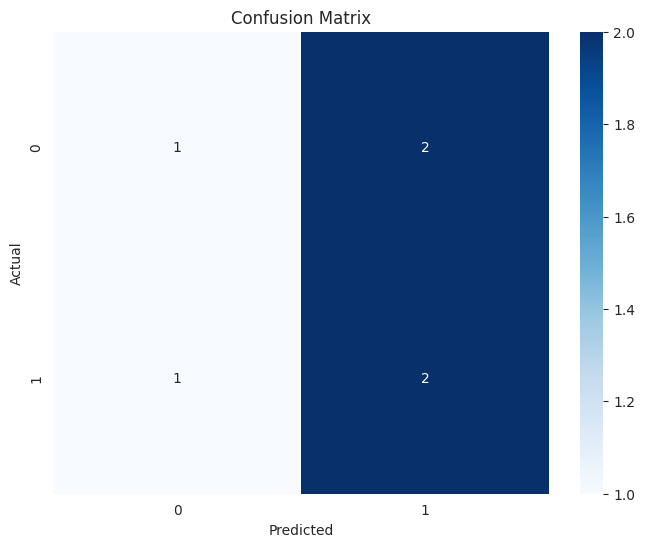

In [6]:
# Make predictions
y_pred = strategy.model.predict(X_test)
y_pred_proba = strategy.model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Model Performance:")
print(f"  Accuracy: {accuracy:.2%}")
print(f"  ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Loss", "Win"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### ROC Curve

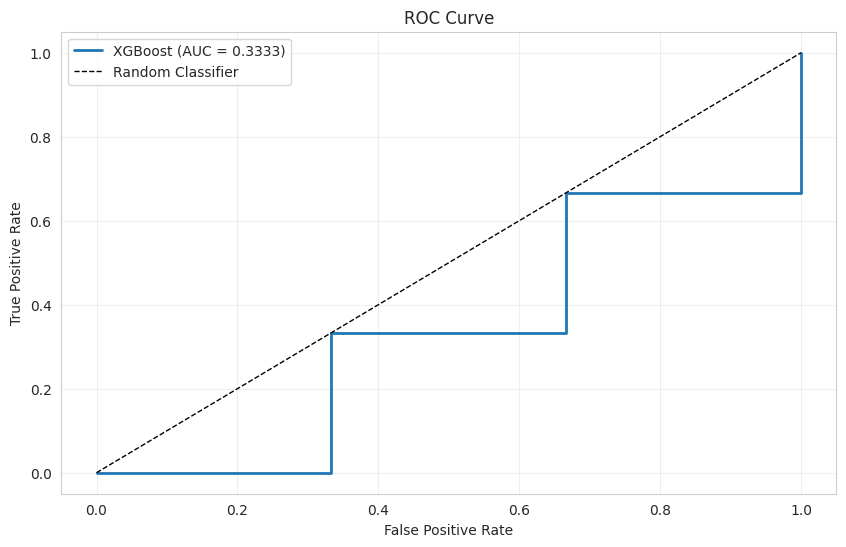

In [7]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"XGBoost (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Calibration Plot

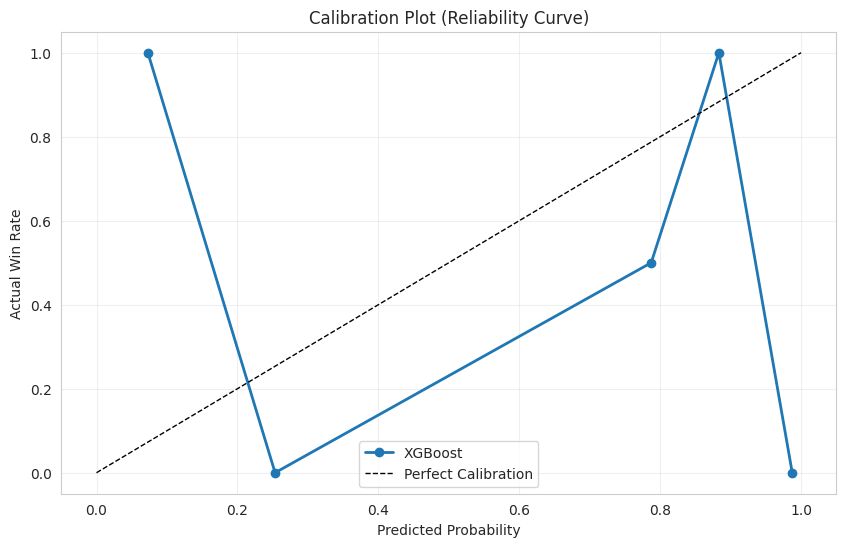

Note: A well-calibrated model has predictions close to the diagonal line.


In [8]:
# Plot calibration (predicted probability vs actual win rate)
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker="o", linewidth=2, label="XGBoost")
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Win Rate")
plt.title("Calibration Plot (Reliability Curve)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Note: A well-calibrated model has predictions close to the diagonal line.")

## 6. Feature Importance

Analyze which features are most important for predictions.

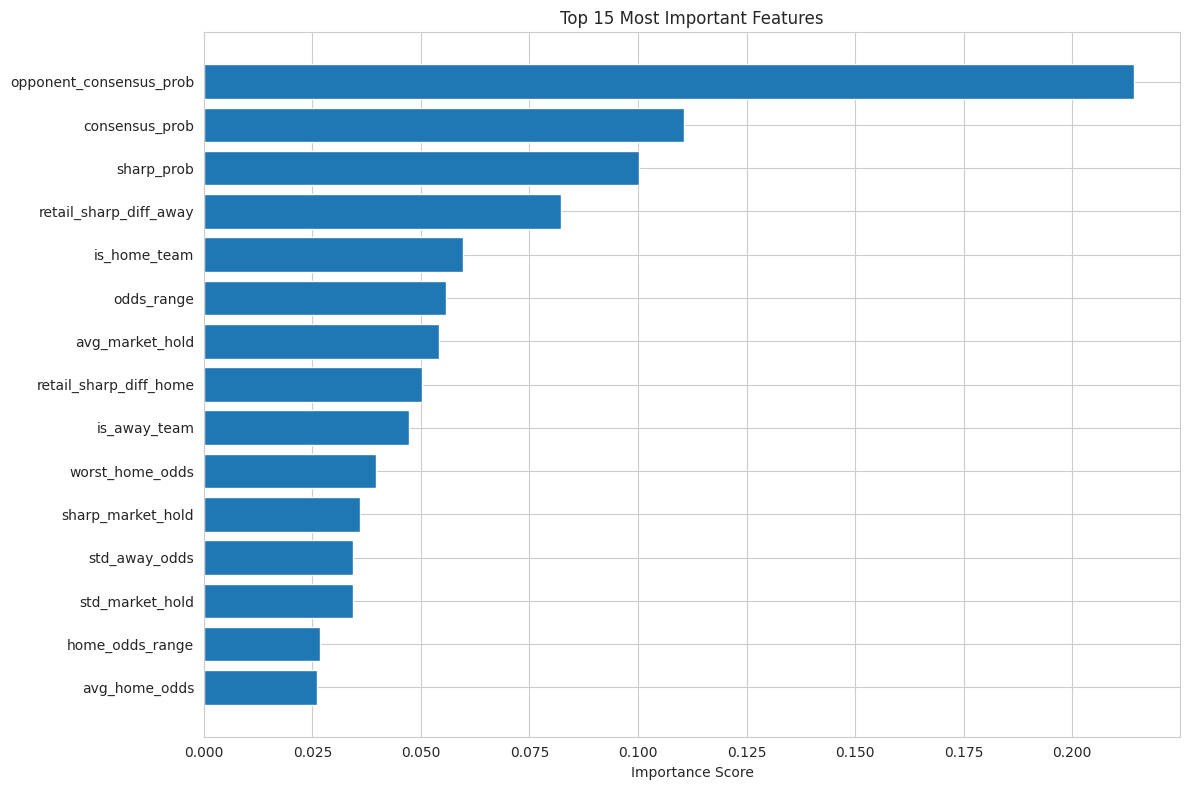


Top 10 Features:
                Feature  Importance
opponent_consensus_prob    0.214165
         consensus_prob    0.110624
             sharp_prob    0.100148
 retail_sharp_diff_away    0.082291
           is_home_team    0.059663
             odds_range    0.055783
        avg_market_hold    0.054251
 retail_sharp_diff_home    0.050228
           is_away_team    0.047146
        worst_home_odds    0.039615


In [9]:
# Get feature importance
feature_importance = strategy.get_feature_importance()

# Sort by importance
importance_df = pd.DataFrame({
    "Feature": list(feature_importance.keys()),
    "Importance": list(feature_importance.values())
}).sort_values("Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features["Importance"])
plt.yticks(range(len(top_features)), top_features["Feature"])
plt.xlabel("Importance Score")
plt.title("Top 15 Most Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance_df.head(10).to_string(index=False))

## 7. Hyperparameter Tuning (Optional)

Use GridSearchCV to find optimal hyperparameters.

In [11]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Grid search with 3-fold cross-validation
xgb = XGBClassifier(random_state=42, eval_metric="logloss")

grid_search = GridSearchCV(
    xgb,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

print("Running grid search (this may take several minutes)...")
grid_search.fit(X_train, y_train)

print("\n✓ Grid search complete")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

print("\nBest Model Test Performance:")
print(f"  Accuracy: {accuracy_best:.2%}")
print(f"  ROC-AUC: {roc_auc_best:.4f}")

# Update strategy with best model
strategy.model = best_model
print("\n✓ Strategy updated with best model")

Running grid search (this may take several minutes)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/andrew/.pyenv/versions/3.12.4/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/andrew/.pyenv/versions/3.12.4/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/andrew/.pyenv/versions/3.12.4/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from 


✓ Grid search complete

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'subsample': 1.0}
Best CV ROC-AUC: 0.6458

Best Model Test Performance:
  Accuracy: 50.00%
  ROC-AUC: 0.4444

✓ Strategy updated with best model


## 8. Save Model

Save the trained model for use in backtesting and production.

In [12]:
# Save model
model_path = "models/xgboost_h2h_v1.pkl"
strategy.save_model(model_path)

print(f"✓ Model saved to {model_path}")
print("\nModel details:")
print(f"  Features: {len(strategy.feature_names)}")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test ROC-AUC: {roc_auc_best:.4f}")

✓ Model saved to models/xgboost_h2h_v1.pkl

Model details:
  Features: 29
  Training samples: 24
  Test ROC-AUC: 0.4444


## 9. Backtest the Strategy

Test the trained model on a separate time period using the backtesting framework.

In [14]:
# Define backtest period (should be different from training period)
BACKTEST_START = TRAIN_END + timedelta(days=1)
BACKTEST_END = BACKTEST_START + timedelta(days=7)

# Load the saved model
backtest_strategy = XGBoostStrategy(
    model_path=model_path,
    min_edge_threshold=0.03,  # Require 3% edge
    min_confidence=0.52       # Only bet if model predicts >52% win probability
)

# Configure backtest with nested config objects
config = BacktestConfig(
    start_date=BACKTEST_START,
    end_date=BACKTEST_END,
    initial_bankroll=10000.0,
    decision_hours_before_game=1.0,
    sizing=BetSizingConfig(
        method="fractional_kelly",
        kelly_fraction=0.25  # Quarter-Kelly for safety
    ),
    constraints=BetConstraintsConfig(
        min_bet_size=10.0,
        max_bet_size=500.0,
        max_bet_percentage=0.05
    )
)

print(f"Running backtest from {BACKTEST_START.date()} to {BACKTEST_END.date()}...")

# Run backtest
async with async_session_maker() as session:
    reader = OddsReader(session)
    engine = BacktestEngine(backtest_strategy, config, reader)
    result = await engine.run()

print("\n✓ Backtest complete")
print(result.to_summary_text())

Running backtest from 2025-11-01 to 2025-11-08...
2025-11-07 16:47:29 [info     ] backtest_starting              end_date=datetime.datetime(2025, 11, 8, 0, 0) start_date=datetime.datetime(2025, 11, 1, 0, 0) strategy=XGBoost
2025-11-07 16:47:29 [info     ] events_loaded                  events_with_results=39 total_events=39


Output()

2025-11-07 16:47:29 [warning  ] no_odds_at_time                event_id=8cf5f0182f14070fbb4decdff17134ed 
tolerance_minutes=30

2025-11-07 16:47:29 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 1, 0, 30, 
tzinfo=datetime.timezone.utc) event_id=8cf5f0182f14070fbb4decdff17134ed

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=a89a548bc7214404c8d7abfe85817c80 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 1, 1, 0, 
tzinfo=datetime.timezone.utc) event_id=a89a548bc7214404c8d7abfe85817c80

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=17245e545f4c4aa961de57270f16b2c7 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 1, 1, 0, 
tzinfo=datetime.timezone.utc) event_id=17245e545f4c4aa961de57270f16b2c7

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=c06e17e4142d0a944fb49b49e0a2de6c 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 1, 1, 30, 
tzinfo=datetime.timezone.utc) event_id=c06e17e4142d0a944fb49b49e0a2de6c

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=c48d638dc464add981a4016759f31262 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 2, 22, 10,
22, tzinfo=datetime.timezone.utc) event_id=c48d638dc464add981a4016759f31262

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=32340eec3e6f948859da513d81047c24 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 2, 22, 10,
58, tzinfo=datetime.timezone.utc) event_id=32340eec3e6f948859da513d81047c24

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=d5520c148eed47ba246ad3ecf8cdf503 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 2, 22, 11,
8, tzinfo=datetime.timezone.utc) event_id=d5520c148eed47ba246ad3ecf8cdf503

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=03056148fcfe2cce81e7025dae4c3dbe 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 2, 22, 12,
tzinfo=datetime.timezone.utc) event_id=03056148fcfe2cce81e7025dae4c3dbe

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=c6d2116d84581cd75fb1360aef5efb6e 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 3, 0, 0, 
tzinfo=datetime.timezone.utc) event_id=c6d2116d84581cd75fb1360aef5efb6e

2025-11-07 16:47:30 [warning  ] no_odds_at_time                event_id=37d2920127740f016f71516a1abe38b8 
tolerance_minutes=30

2025-11-07 16:47:30 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 3, 1, 30, 
tzinfo=datetime.timezone.utc) event_id=37d2920127740f016f71516a1abe38b8

2025-11-07 16:47:31 [warning  ] no_odds_at_time                event_id=f339c535ada11624c8dcb320f9f12987 
tolerance_minutes=30

2025-11-07 16:47:31 [debug    ] no_odds_at_decision_time       decision_time=datetime.datetime(2025, 11, 7, 1, 10, 
37, tzinfo=datetime.timezone.utc) event_id=f339c535ada11624c8dcb320f9f12987

2025-11-07 16:47:31 [info     ] backtest_complete              final_bankroll=8592.996014636918 roi=-14.070039853630822 total_bets=26

✓ Backtest complete

╔═══════════════════════════════════════════════════════════════╗
║         Backtest Results - XGBoost                        ║
╠═══════════════════════════════════════════════════════════════╣
║ Period:           2025-11-01 to 2025-11-08                   ║
║ Total Days:       7                                              ║
║ Initial Bankroll: $10,000.00                                  ║
║ Final Bankroll:   $8,593.00                                   ║
║ Total Profit:     $-1,407.00 ✗                               ║
║                                                               ║
║ PERFORMANCE METRICS                                           ║
║ ├─ ROI:              -14.07%                                    ║
║ ├─ Total Bets:       26                                        ║
║ ├─ Win Rate:         65.38% (17W / 9L)        ║
║ 

### Analyze Results

✓ Results saved
  JSON: backtest_results_xgboost.json
  CSV: backtest_bets_xgboost.csv


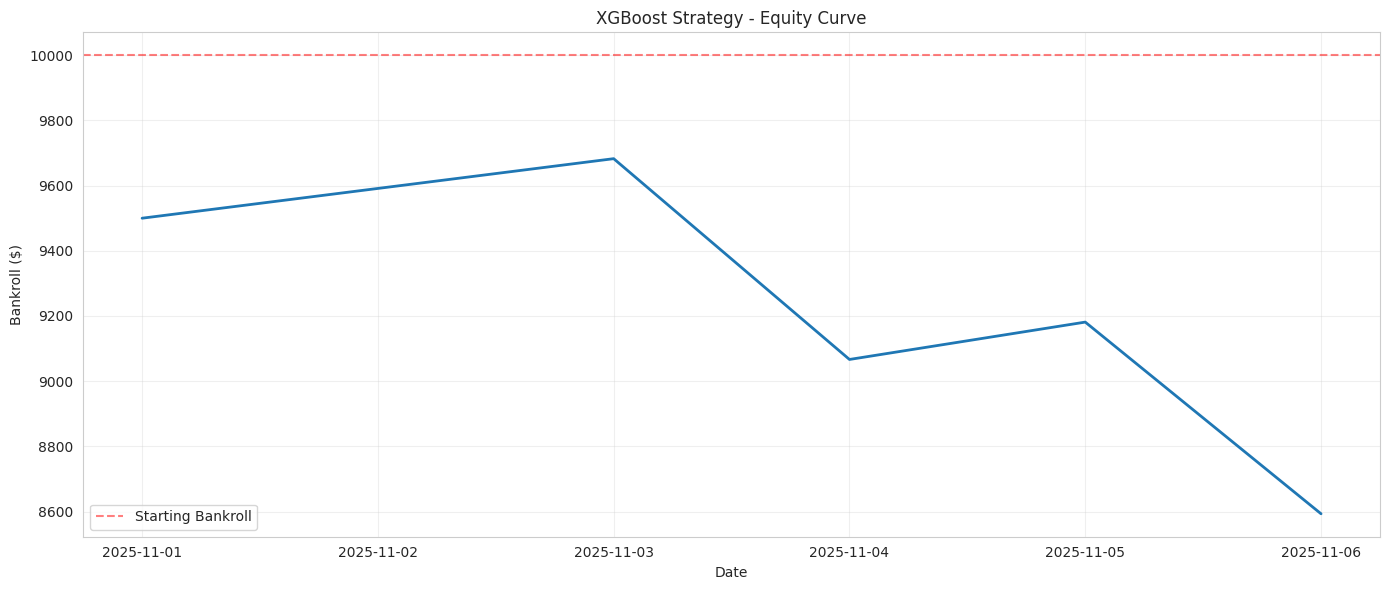


Key Metrics:
  Total Bets: 26
  Win Rate: 65.38%
  ROI: -14.07%
  Total Profit: $-1,407.00
  Sharpe Ratio: -0.71
  Max Drawdown: $1,501.43 (-14.87%)


In [15]:
# Save results
result.to_json("backtest_results_xgboost.json")
result.to_csv("backtest_bets_xgboost.csv")

print("✓ Results saved")
print("  JSON: backtest_results_xgboost.json")
print("  CSV: backtest_bets_xgboost.csv")

# Plot equity curve
equity_df = pd.DataFrame([
    {"date": point.date, "bankroll": point.bankroll}
    for point in result.equity_curve
])

plt.figure(figsize=(14, 6))
plt.plot(equity_df["date"], equity_df["bankroll"], linewidth=2)
plt.axhline(y=config.initial_bankroll, color="r", linestyle="--", alpha=0.5, label="Starting Bankroll")
plt.xlabel("Date")
plt.ylabel("Bankroll ($)")
plt.title("XGBoost Strategy - Equity Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Metrics:")
print(f"  Total Bets: {result.total_bets}")
print(f"  Win Rate: {result.win_rate:.2f}%")
print(f"  ROI: {result.roi:.2f}%")
print(f"  Total Profit: ${result.total_profit:,.2f}")
print(f"  Sharpe Ratio: {result.sharpe_ratio:.2f}")
print(f"  Max Drawdown: ${abs(result.max_drawdown):,.2f} ({result.max_drawdown_percentage:.2f}%)")

## 10. Summary

This notebook demonstrated:

1. **Data Preparation**: Loading historical events with odds snapshots
2. **Feature Engineering**: Extracting 15+ features capturing market dynamics
3. **Model Training**: XGBoost classifier with hyperparameter tuning
4. **Evaluation**: ROC-AUC, calibration, feature importance analysis
5. **Backtesting**: Seamless integration with backtesting framework

### Next Steps

- **Improve Features**: Add more sophisticated features (e.g., team stats, injuries)
- **Feature Selection**: Use recursive feature elimination to reduce overfitting
- **Model Ensembles**: Combine XGBoost with other models (LightGBM, Neural Networks)
- **Time-Series Validation**: Use walk-forward analysis instead of random split
- **Spread/Totals Models**: Train separate models for spread and totals markets
- **Production Deployment**: Integrate with live odds fetching for real-time predictions

### Using This Pattern for Other Models

This workflow can be adapted for:
- **LightGBM**: Similar to XGBoost but potentially faster
- **Neural Networks**: Use PyTorch/TensorFlow for deep learning
- **Time Series Models**: LSTM/GRU for sequential line movement patterns
- **Ensemble Methods**: Stack multiple models for better predictions

See `analytics/ml_strategy_example.py` for implementation details.